<a href="https://colab.research.google.com/github/raghunadh-eva/eva6/blob/master/S7_ASSIGNMENT/CODE4_84.85_STEPLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Basic setup block**


*   Load the required utils/libraries
*   Setup the transformations needed to load the data
*   Split the input data into train and test
*   Create the train and test data objects





In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
!pip install torchsummary
from torchsummary import summary
import numpy as np

In [2]:
!pip install -U albumentations
import albumentations as A
import cv2


import albumentations as A
from albumentations.pytorch import ToTensorV2

     |████████████████████████████████| 102kB 5.0MB/s 
     |████████████████████████████████| 38.2MB 74kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
test_transforms  = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.2435,0.2616))
                                      ])

In [4]:
train_transforms_a = A.Compose([
                                       A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616)),
                                       A.HorizontalFlip(p=0.5),
                                       A.ShiftScaleRotate(),
                                       A.CoarseDropout(max_holes=1,max_height=16,max_width=16,min_holes=1,min_height=16,min_width=16,fill_value=(0.4914, 0.4822, 0.4465),mask_fill_value=None),
                                       ToTensorV2()
                                       ])

In [5]:
import cv2
import torchvision

##copied from albumentations.io
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

class data_albumentations(datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label



In [6]:
#train = datasets.CIFAR10('./data', train=True,  download=True, transform=train_transforms)
train = data_albumentations(train=True,  download=True, transform=train_transforms_a)
test =  datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)



Extracting /root/data/cifar10/cifar-10-python.tar.gz to /root/data/cifar10



Extracting ./data/cifar-10-python.tar.gz to ./data


In [7]:
#Always start with same random set everytime
SEED = 1

#Is GPU ?
cuda = torch.cuda.is_available()

print('CUDA Available?',cuda)

#what happens when SEED = 2 ?
torch.manual_seed(SEED)

#set the seed for GPU device as well
if cuda:
  torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")
print(device)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#Why change batch_size for CPU - since it should not matter

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)


test_loader  = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

##Why shuffle=false in the example provided ?

CUDA Available? True
cuda


**Visualize the input data with image standardization**


In [8]:
image_loader = torch.utils.data.DataLoader(train, shuffle=True,batch_size=4)

def imshow(img):
    npimg = img.numpy()
    npimg[0] = (npimg[0] * 0.247) + 0.4914
    npimg[1] = (npimg[1] * 0.2435) + 0.4822
    npimg[2] = (npimg[2] * 0.2616) + 0.4465
    #we can use this directly but simply converting to tensor and converting back
    timg = torch.from_numpy(npimg)
    nimg = timg.numpy()
    plt.imshow(np.transpose(nimg, (1, 2, 0)))

# get some random training images
dataiter = iter(image_loader)
images, labels = dataiter.next()

# show images
#imshow(torchvision.utils.make_grid(images))
#print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**Visualize the input data without image standardization**



In [9]:
#Comment this block from CODE2 onwards
train_nonorm_transforms = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                       ])
test_nonorm_transforms  = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                      ])
train_nonorm = datasets.CIFAR10('./data_nonorm', train=True,  download=True, transform=train_nonorm_transforms)
test_nonorm =  datasets.CIFAR10('./data_nonorm', train=False, download=True, transform=test_nonorm_transforms)
train_loader_nonorm = torch.utils.data.DataLoader(train_nonorm, **dataloader_args)
test_loader_nonorm  = torch.utils.data.DataLoader(test_nonorm, **dataloader_args)


Extracting ./data_nonorm/cifar-10-python.tar.gz to ./data_nonorm
Files already downloaded and verified


In [10]:
chsum = 0
##pbar = tqdm(train_loader_nonorm)

for index, (data,target) in enumerate(train_loader_nonorm):
    chsum += data.sum(dim=(0,2,3),keepdim=True)

mean = chsum / (len(train_nonorm) * 32 *32)
#
chsum = None
for index, (data,target) in enumerate(train_loader_nonorm):
  if index == 0:
   print(data.min(),data.max())
   chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
  else:
   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

std = torch.sqrt(chsum/(len(train_nonorm) * 32 * 32))
print("Traindata Mean",mean)
print("Traindata std dev",std)

chsum = 0

for index, (data,target) in enumerate(test_loader_nonorm):
    chsum += data.sum(dim=(0,2,3),keepdim=True)

mean = chsum / (len(test_nonorm) * 32 *32)

chsum = None
for index, (data,target) in enumerate(test_loader_nonorm):
  if index == 0:
    chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
  else:
   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

std = torch.sqrt(chsum/(len(test_nonorm) * 32 * 32))
print("Test data Mean",mean)
print("Test data std dev",std)

tensor(0.) tensor(1.)
Traindata Mean tensor([[[[0.4914]],

         [[0.4822]],

         [[0.4465]]]])
Traindata std dev tensor([[[[0.2470]],

         [[0.2435]],

         [[0.2616]]]])
Test data Mean tensor([[[[0.4942]],

         [[0.4851]],

         [[0.4504]]]])
Test data std dev tensor([[[[0.2467]],

         [[0.2429]],

         [[0.2616]]]])


car


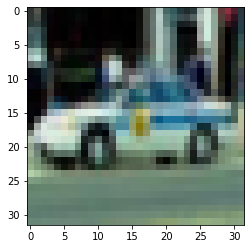

In [11]:
dataiter = iter(train_loader_nonorm)
images, labels = dataiter.next()

def imshow_nonorm(img):
    img = img     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
imshow_nonorm(torchvision.utils.make_grid(images[10]))

print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**####Batch Normalization + L1 LOSS**

In [12]:
dropout_perc = 0.05

class BatchNormNet(nn.Module):
    def __init__(self):
        super(BatchNormNet, self).__init__()

        #BLOCK C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32 ; #Receptive field = 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32; #Receptive field = 5x5
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32; #Receptive field = 7x7

        self.convblock16 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups=64, kernel_size=(3, 3), padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32; #Receptive field = 7x7


        #BLOCK C1 TRANSITION
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32; #Receptive field = 7x7

        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16 ; #Receptive field = 8x8
        #Drop maxPooling and use strided convolution
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=2, dilation =2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        #Use dilated kernels instead of Max pooling
        #self.pool1 = nn.Sequential(
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #    nn.Dropout(dropout_perc),
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #    nn.Dropout(dropout_perc),
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #    nn.Dropout(dropout_perc),
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #   nn.Dropout(dropout_perc)
        #    #nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        #)
        #BLOCK C2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5

        
        #BLOCK C2 TRANSITION
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16; #Receptive field = 5x5
        
        
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ; #Receptive field = 8x8
        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=2, dilation = 2,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )

        #BLOCK C3
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5
        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5

        #BLOCK C3 TRANSITION
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16; #Receptive field = 5x5
        
        
        #BLOCK C4
        
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 8; #Receptive field = 5x5
        
        self.convblock12 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64 , kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 8; #Receptive field = 5x5

        self.convblock25 = nn.Sequential(
            nn.Conv2d(in_channels=128, groups = 128, out_channels=256, kernel_size=(3, 3), padding=0, bias=False)
            #n.BatchNorm2d(256),
            #nn.ReLU(),
            #nn.Dropout(dropout_perc)
        ) # output_size = 8; #Receptive field = 5x5

                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock13 = nn.Sequential(
            nn.Linear(256,10,0)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock16(x)
        x = self.convblock4(x)
        
        x = self.pool1(x)
        
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = self.pool2(x)

        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)

        
        x = self.convblock11(x)
        x = self.convblock12(x)
        x = self.convblock25(x)
        x = self.gap(x)
        
        x = x.view(x.size(0), -1)
        x = self.convblock13(x)
   
        return F.log_softmax(x, dim=-1)

In [13]:
#model = BatchNormNet().to(device)
#summary(model, input_size=(3, 32, 32))

####LayerNorm Normalization + L1 LOSS

**`####Group normalization network + L1 LOSS`**

In [14]:
from tqdm import tqdm

test_fail_data = []
test_fail_target = []
test_pred_target = []
test_losses = []
test_acc = []
train_acc = []
train_losses = []

loss_function = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  l1_lamda = 0.0001
  
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #Cross entropy loss
    #loss = F.nll_loss(y_pred, target)
    loss = loss_function(y_pred,target)
    #

    ##Add L1 Loss
    l1 = 0
    for p in model.parameters():
      p_tensor = torch.sum(torch.abs(p))
      l1 += p_tensor

    loss = loss + l1_lamda * l1
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    test_fail_data = []
    test_fail_target = []
    test_pred_target = []

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #print(pred,target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            for i,x in enumerate(pred.eq(target.view_as(pred))):
              if not x:
                test_fail_data.append(data[i])
                test_fail_target.append(target[i])
                test_pred_target.append(pred[i])
                #print(target[i])

    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target;

**####Block to pass argment and call the Model**

Pass the model to be Invoked based on Input Argument

In [15]:
def main(input_model_type,EPOCHS):
  if input_model_type == 0:
    model = BatchNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 1:
    model = LayerNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 2:
    model = GroupNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  else:
    print("Invalid input for input_model_type",input_model_type)
    print("Supported values are 0 = Batch Norm,1 = Layer Norm,2 = Group Norm")

def run_train_test(model,EPOCHS,input_model_type):
  summary(model, input_size=(3, 32, 32))
  optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
  scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=20, gamma=0.7)

  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    
    scheduler.step()
    
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    train(model, device, train_loader, optimizer, epoch)
    
    test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target = test(model, device, test_loader)
  
  #print(test_fail_data)
  fig, axs = plt.subplots(1, 2)
  if input_model_type == 0:
    fig.suptitle('Model Type: Batch normalization')
  if input_model_type == 1:
    fig.suptitle('Model Type: Layer normalization')
  if input_model_type == 2:
    fig.suptitle('Model Type: Group normalization')
  
  axs[0].set_title('Test/Validation Loss Graph')
  axs[0].set_xticks(np.arange(1,EPOCHS+1))
  #axs[0].xlabel('Test/Validation Loss Graph')
  #axs[0].ylabel('LOSS')
  axs[1].set_title('Test/Validation Accuracy Graph')
  axs[1].set_xticks(np.arange(1,EPOCHS+1))
  #axs[1].xlabel('Test/Validation Accuracy Graph')
  #axs[1].ylabel('Accuracy')
  
  axs[0].plot(test_losses)
  axs[1].plot(test_acc)

  test_10_images = []
  for i in range(0,10):
    test_10_images.append(test_fail_data[i])
  
  test_10_images_target = []
  for i in range(0,10):
    test_10_images_target.append(test_fail_target[i])

  test_10_pred_target = []
  for i in range(0,10):
    test_10_pred_target.append(test_pred_target[i])
  #print(test_10_images_target)

  print('Actual Labels')
  print(' '.join('%5s' % classes[test_10_images_target[j]] for j in range(0,10)))
  print('Predicted Labels')
  print(' '.join('%5s' % classes[test_10_pred_target[j]] for j in range(0,10)))

  test_10_images_unnorm = []
  for img in test_10_images:
    img = img.cpu()
    img = img.numpy()
    img[0] = img[0] * 0.247 + 0.4914
    img[1] = img[1] * 0.2435 + 0.4822
    img[2] = img[2] * 0.2616 + 0.4465

    img = torch.from_numpy(img)
    test_10_images_unnorm.append(img)
  
  grid = torchvision.utils.make_grid(torch.stack(test_10_images).cpu(), nrow=5)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

  return test_10_images, test_10_images_target , test_10_pred_target;

**####Call to main function**

main(input_model_type,EPOCHS)

input_model_type:

Supported values are

0 = Train a model with Batch normalization

1 = Train a model with Layer normalization

2 = Train a model with Group Normalization

EPOCHS: num_epochs


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/391 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,432
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]           1,152
      BatchNorm2d-14          [-1, 128,

Loss=2.144700050354004 Batch_id=390 Accuracy=34.98: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 13723.4121, Accuracy: 4991/10000 (49.91%)

EPOCH: 1
Epoch 1, lr 0.02


Loss=1.608634114265442 Batch_id=390 Accuracy=48.82: 100%|██████████| 391/391 [00:42<00:00,  9.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 10759.6250, Accuracy: 6176/10000 (61.76%)

EPOCH: 2
Epoch 2, lr 0.02


Loss=1.5441646575927734 Batch_id=390 Accuracy=55.14: 100%|██████████| 391/391 [00:42<00:00,  9.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9837.3409, Accuracy: 6480/10000 (64.80%)

EPOCH: 3
Epoch 3, lr 0.02


Loss=1.5680689811706543 Batch_id=390 Accuracy=58.14: 100%|██████████| 391/391 [00:42<00:00,  9.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9071.3290, Accuracy: 6792/10000 (67.92%)

EPOCH: 4
Epoch 4, lr 0.02


Loss=1.5464035272598267 Batch_id=390 Accuracy=60.31: 100%|██████████| 391/391 [00:42<00:00,  9.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8310.4252, Accuracy: 7082/10000 (70.82%)

EPOCH: 5
Epoch 5, lr 0.02


Loss=1.5154671669006348 Batch_id=390 Accuracy=62.30: 100%|██████████| 391/391 [00:42<00:00,  9.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7809.0651, Accuracy: 7318/10000 (73.18%)

EPOCH: 6
Epoch 6, lr 0.02


Loss=1.3943290710449219 Batch_id=390 Accuracy=63.81: 100%|██████████| 391/391 [00:42<00:00,  9.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7862.8262, Accuracy: 7244/10000 (72.44%)

EPOCH: 7
Epoch 7, lr 0.02


Loss=1.650298833847046 Batch_id=390 Accuracy=64.46: 100%|██████████| 391/391 [00:42<00:00,  9.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7449.4696, Accuracy: 7433/10000 (74.33%)

EPOCH: 8
Epoch 8, lr 0.02


Loss=1.532867193222046 Batch_id=390 Accuracy=65.44: 100%|██████████| 391/391 [00:42<00:00,  9.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7775.1288, Accuracy: 7315/10000 (73.15%)

EPOCH: 9
Epoch 9, lr 0.02


Loss=1.3213715553283691 Batch_id=390 Accuracy=66.28: 100%|██████████| 391/391 [00:42<00:00,  9.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6981.1221, Accuracy: 7591/10000 (75.91%)

EPOCH: 10
Epoch 10, lr 0.02


Loss=1.4881606101989746 Batch_id=390 Accuracy=66.94: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6690.7863, Accuracy: 7720/10000 (77.20%)

EPOCH: 11
Epoch 11, lr 0.02


Loss=1.60292387008667 Batch_id=390 Accuracy=67.43: 100%|██████████| 391/391 [00:42<00:00,  9.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6991.5610, Accuracy: 7610/10000 (76.10%)

EPOCH: 12
Epoch 12, lr 0.02


Loss=1.2789437770843506 Batch_id=390 Accuracy=67.58: 100%|██████████| 391/391 [00:42<00:00,  9.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7083.3520, Accuracy: 7563/10000 (75.63%)

EPOCH: 13
Epoch 13, lr 0.02


Loss=1.5594029426574707 Batch_id=390 Accuracy=67.84: 100%|██████████| 391/391 [00:42<00:00,  9.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6324.4333, Accuracy: 7792/10000 (77.92%)

EPOCH: 14
Epoch 14, lr 0.02


Loss=1.4982925653457642 Batch_id=390 Accuracy=68.65: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6763.1424, Accuracy: 7716/10000 (77.16%)

EPOCH: 15
Epoch 15, lr 0.02


Loss=1.2621214389801025 Batch_id=390 Accuracy=68.77: 100%|██████████| 391/391 [00:42<00:00,  9.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6766.2519, Accuracy: 7662/10000 (76.62%)

EPOCH: 16
Epoch 16, lr 0.02


Loss=1.2275187969207764 Batch_id=390 Accuracy=69.36: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6535.9106, Accuracy: 7775/10000 (77.75%)

EPOCH: 17
Epoch 17, lr 0.02


Loss=1.3449046611785889 Batch_id=390 Accuracy=69.35: 100%|██████████| 391/391 [00:42<00:00,  9.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6170.9797, Accuracy: 7913/10000 (79.13%)

EPOCH: 18
Epoch 18, lr 0.02


Loss=1.338648796081543 Batch_id=390 Accuracy=69.84: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6143.0986, Accuracy: 7860/10000 (78.60%)

EPOCH: 19
Epoch 19, lr 0.013999999999999999


Loss=1.3823658227920532 Batch_id=390 Accuracy=71.38: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5620.3325, Accuracy: 8054/10000 (80.54%)

EPOCH: 20
Epoch 20, lr 0.013999999999999999


Loss=1.2141611576080322 Batch_id=390 Accuracy=71.61: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5373.2643, Accuracy: 8150/10000 (81.50%)

EPOCH: 21
Epoch 21, lr 0.013999999999999999


Loss=1.2163689136505127 Batch_id=390 Accuracy=71.74: 100%|██████████| 391/391 [00:42<00:00,  9.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5757.3201, Accuracy: 8013/10000 (80.13%)

EPOCH: 22
Epoch 22, lr 0.013999999999999999


Loss=1.3347280025482178 Batch_id=390 Accuracy=71.95: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6127.1129, Accuracy: 7896/10000 (78.96%)

EPOCH: 23
Epoch 23, lr 0.013999999999999999


Loss=1.1200944185256958 Batch_id=390 Accuracy=71.87: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5443.8663, Accuracy: 8131/10000 (81.31%)

EPOCH: 24
Epoch 24, lr 0.013999999999999999


Loss=1.3292186260223389 Batch_id=390 Accuracy=72.19: 100%|██████████| 391/391 [00:42<00:00,  9.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5878.5823, Accuracy: 7953/10000 (79.53%)

EPOCH: 25
Epoch 25, lr 0.013999999999999999


Loss=1.1975760459899902 Batch_id=390 Accuracy=72.11: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5652.1143, Accuracy: 8057/10000 (80.57%)

EPOCH: 26
Epoch 26, lr 0.013999999999999999


Loss=1.048319935798645 Batch_id=390 Accuracy=72.43: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6165.7950, Accuracy: 7907/10000 (79.07%)

EPOCH: 27
Epoch 27, lr 0.013999999999999999


Loss=1.2275421619415283 Batch_id=390 Accuracy=72.38: 100%|██████████| 391/391 [00:42<00:00,  9.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5648.3846, Accuracy: 8051/10000 (80.51%)

EPOCH: 28
Epoch 28, lr 0.013999999999999999


Loss=1.4517877101898193 Batch_id=390 Accuracy=72.36: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5610.5072, Accuracy: 8055/10000 (80.55%)

EPOCH: 29
Epoch 29, lr 0.013999999999999999


Loss=1.1558098793029785 Batch_id=390 Accuracy=72.63: 100%|██████████| 391/391 [00:42<00:00,  9.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5346.6915, Accuracy: 8161/10000 (81.61%)

EPOCH: 30
Epoch 30, lr 0.013999999999999999


Loss=1.441171646118164 Batch_id=390 Accuracy=72.79: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5374.4948, Accuracy: 8125/10000 (81.25%)

EPOCH: 31
Epoch 31, lr 0.013999999999999999


Loss=1.2790257930755615 Batch_id=390 Accuracy=72.58: 100%|██████████| 391/391 [00:42<00:00,  9.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5412.3503, Accuracy: 8158/10000 (81.58%)

EPOCH: 32
Epoch 32, lr 0.013999999999999999


Loss=1.0604133605957031 Batch_id=390 Accuracy=73.00: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5033.3042, Accuracy: 8300/10000 (83.00%)

EPOCH: 33
Epoch 33, lr 0.013999999999999999


Loss=1.2578538656234741 Batch_id=390 Accuracy=73.03: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6022.4877, Accuracy: 7906/10000 (79.06%)

EPOCH: 34
Epoch 34, lr 0.013999999999999999


Loss=1.3850133419036865 Batch_id=390 Accuracy=73.13: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5580.6679, Accuracy: 8075/10000 (80.75%)

EPOCH: 35
Epoch 35, lr 0.013999999999999999


Loss=1.2894155979156494 Batch_id=390 Accuracy=73.22: 100%|██████████| 391/391 [00:42<00:00,  9.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5280.6701, Accuracy: 8209/10000 (82.09%)

EPOCH: 36
Epoch 36, lr 0.013999999999999999


Loss=1.0177216529846191 Batch_id=390 Accuracy=73.60: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5318.6043, Accuracy: 8139/10000 (81.39%)

EPOCH: 37
Epoch 37, lr 0.013999999999999999


Loss=1.1463817358016968 Batch_id=390 Accuracy=73.06: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5283.0247, Accuracy: 8177/10000 (81.77%)

EPOCH: 38
Epoch 38, lr 0.013999999999999999


Loss=1.415085792541504 Batch_id=390 Accuracy=73.46: 100%|██████████| 391/391 [00:42<00:00,  9.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5017.2273, Accuracy: 8300/10000 (83.00%)

EPOCH: 39
Epoch 39, lr 0.009799999999999998


Loss=1.227664589881897 Batch_id=390 Accuracy=74.77: 100%|██████████| 391/391 [00:42<00:00,  9.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4879.6434, Accuracy: 8337/10000 (83.37%)

EPOCH: 40
Epoch 40, lr 0.009799999999999998


Loss=1.5148028135299683 Batch_id=390 Accuracy=74.75: 100%|██████████| 391/391 [00:42<00:00,  9.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4978.4587, Accuracy: 8250/10000 (82.50%)

EPOCH: 41
Epoch 41, lr 0.009799999999999998


Loss=1.2455873489379883 Batch_id=390 Accuracy=74.74: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4979.5453, Accuracy: 8291/10000 (82.91%)

EPOCH: 42
Epoch 42, lr 0.009799999999999998


Loss=1.1655564308166504 Batch_id=390 Accuracy=75.09: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4970.1657, Accuracy: 8323/10000 (83.23%)

EPOCH: 43
Epoch 43, lr 0.009799999999999998


Loss=1.2034721374511719 Batch_id=390 Accuracy=74.97: 100%|██████████| 391/391 [00:42<00:00,  9.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4854.6774, Accuracy: 8346/10000 (83.46%)

EPOCH: 44
Epoch 44, lr 0.009799999999999998


Loss=1.1959705352783203 Batch_id=390 Accuracy=74.89: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5079.5174, Accuracy: 8260/10000 (82.60%)

EPOCH: 45
Epoch 45, lr 0.009799999999999998


Loss=1.2120448350906372 Batch_id=390 Accuracy=75.15: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4852.3077, Accuracy: 8337/10000 (83.37%)

EPOCH: 46
Epoch 46, lr 0.009799999999999998


Loss=1.3148188591003418 Batch_id=390 Accuracy=75.11: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4803.8690, Accuracy: 8366/10000 (83.66%)

EPOCH: 47
Epoch 47, lr 0.009799999999999998


Loss=1.2754100561141968 Batch_id=390 Accuracy=75.21: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4744.1497, Accuracy: 8366/10000 (83.66%)

EPOCH: 48
Epoch 48, lr 0.009799999999999998


Loss=1.1552499532699585 Batch_id=390 Accuracy=75.08: 100%|██████████| 391/391 [00:42<00:00,  9.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4820.3916, Accuracy: 8309/10000 (83.09%)

EPOCH: 49
Epoch 49, lr 0.009799999999999998


Loss=1.0871872901916504 Batch_id=390 Accuracy=75.02: 100%|██████████| 391/391 [00:42<00:00,  9.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4942.9865, Accuracy: 8289/10000 (82.89%)

EPOCH: 50
Epoch 50, lr 0.009799999999999998


Loss=1.051905870437622 Batch_id=390 Accuracy=75.32: 100%|██████████| 391/391 [00:42<00:00,  9.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4756.3963, Accuracy: 8381/10000 (83.81%)

EPOCH: 51
Epoch 51, lr 0.009799999999999998


Loss=1.2761220932006836 Batch_id=390 Accuracy=75.39: 100%|██████████| 391/391 [00:42<00:00,  9.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4815.5149, Accuracy: 8348/10000 (83.48%)

EPOCH: 52
Epoch 52, lr 0.009799999999999998


Loss=1.250970482826233 Batch_id=390 Accuracy=75.37: 100%|██████████| 391/391 [00:42<00:00,  9.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4700.9527, Accuracy: 8407/10000 (84.07%)

EPOCH: 53
Epoch 53, lr 0.009799999999999998


Loss=1.0491375923156738 Batch_id=390 Accuracy=75.06: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4656.6949, Accuracy: 8401/10000 (84.01%)

EPOCH: 54
Epoch 54, lr 0.009799999999999998


Loss=1.21317458152771 Batch_id=390 Accuracy=75.37: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4785.6105, Accuracy: 8350/10000 (83.50%)

EPOCH: 55
Epoch 55, lr 0.009799999999999998


Loss=1.1423895359039307 Batch_id=390 Accuracy=75.62: 100%|██████████| 391/391 [00:42<00:00,  9.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5002.6251, Accuracy: 8297/10000 (82.97%)

EPOCH: 56
Epoch 56, lr 0.009799999999999998


Loss=1.1769447326660156 Batch_id=390 Accuracy=75.48: 100%|██████████| 391/391 [00:42<00:00,  9.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4689.8856, Accuracy: 8384/10000 (83.84%)

EPOCH: 57
Epoch 57, lr 0.009799999999999998


Loss=1.009281873703003 Batch_id=390 Accuracy=75.48: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4516.0780, Accuracy: 8453/10000 (84.53%)

EPOCH: 58
Epoch 58, lr 0.009799999999999998


Loss=1.1347134113311768 Batch_id=390 Accuracy=75.35: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4931.3953, Accuracy: 8307/10000 (83.07%)

EPOCH: 59
Epoch 59, lr 0.006859999999999998


Loss=1.0439317226409912 Batch_id=390 Accuracy=76.45: 100%|██████████| 391/391 [00:42<00:00,  9.18it/s]



Test set: Average loss: 4466.5500, Accuracy: 8485/10000 (84.85%)

Actual Labels
 deer   cat  bird horse  bird  bird  ship  frog   dog horse
Predicted Labels
 frog   dog   cat truck plane  deer plane horse   cat plane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


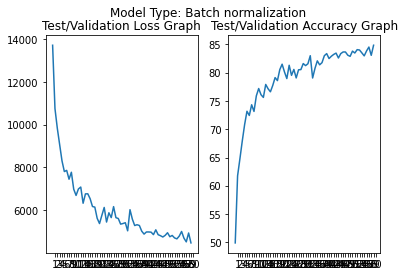

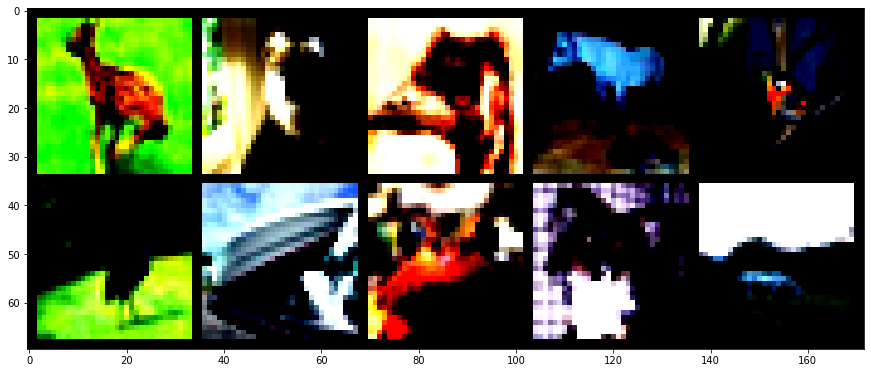

In [16]:
test_10_images, test_10_images_target , test_10_pred_target = main(0,60)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


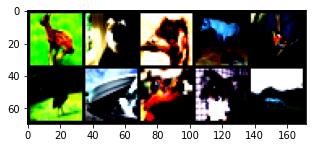

In [18]:
  grid = torchvision.utils.make_grid(torch.stack(test_10_images).cpu(), nrow=5)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

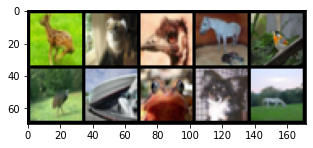

In [22]:
test_10_images_unnorm = []
for img in test_10_images:
  img = img.cpu()
  img = img.numpy()
  img[0] = img[0] * 0.247 + 0.4914
  img[1] = img[1] * 0.2435 + 0.4822
  img[2] = img[2] * 0.2616 + 0.4465

  img = torch.from_numpy(img)
  test_10_images_unnorm.append(img)

grid = torchvision.utils.make_grid(torch.stack(test_10_images_unnorm).cpu(), nrow=5)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(grid, (1,2,0)))
  
